# Simulación de Stock

Sebastián P. Pincheira\
Desarrollador Ocho Fuegos\
sebastian.pincheira@ug.uchile.cl\
+56 9 8918 6914

## Modelamiento

In [291]:
import numpy as np
import scipy.stats as stats
from scipy.integrate import cumulative_trapezoid
import matplotlib.pyplot as plt
import pandas as pd
import random
from tqdm import tqdm

import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'src', 'backend')))

from classes import Packing, Material

SEED = 115

np.random.seed(SEED)

Modelamos velocidad de entrada de KG a un packing mediante una *bump function*. En este caso utilizamos
$$V(t)=\begin{cases}
\exp\left(1-\left(\frac{9}{9 - t^2}\right)^{20}\right) & |x|\leq 1\\
0 & \text{en otro caso}
\end{cases}$$

In [292]:
def bump_function(x):
        # Ensure `x` is an array, even if it is a single number
        x = np.asarray(x)
        result = np.zeros_like(x)
        mask = np.abs(x) < 1
        result[mask] = np.exp(-1 / (1 - (x[mask] / 3) ** 2) ** 20) * np.exp(1)
        return (
            result if result.size > 1 else result.item()
        )  # Return scalar if input was scalar

def noisy_bump(x, length_scale=0.1):
    
    def smooth_noise(x, length_scale=0.1):
        # Ensure `x` is an array, even if it is a single number
        x = np.asarray(x)
        if np.ndim(x) == 0:  # If x is a scalar
            x = np.array([x])
        n_points = len(x)

        # Define covariance matrix using the Gaussian kernel
        covariance_matrix = np.exp(-0.5 * (np.subtract.outer(x, x) / length_scale) ** 2)

        # Generate smooth noise as a sample from a multivariate normal distribution
        noise = np.random.multivariate_normal(
            mean=np.zeros(n_points), cov=covariance_matrix
        )
        return (
            noise if noise.size > 1 else noise.item()
        )  # Return scalar if input was scalar

    f = bump_function(x)
    wide_noise = smooth_noise(1/1000 * x, length_scale) / 10
    medium_noise = smooth_noise(1/2 * x, length_scale) / 10
    narrow_noise = smooth_noise(20 * x, length_scale) / 10
    return abs(f + (wide_noise + medium_noise + narrow_noise) * np.exp(-((2 * x) ** 2)))


def descrete_noisy_bump(support: int, maximum: float, length_scale=0.1, num_points=100):
    def scaled_noisy_bump(support: int, maximum: float, length_scale=0.1):
        """
        Function that returns a bump function supported at `support` and scaled to have maximum value `maximum`.
        The center of the bump is at the center of the support.
        """
        def fun(x):
            return maximum * noisy_bump(
                (x - support / 2) / (support / 2),
                length_scale,
            )
        return fun

    fun = scaled_noisy_bump(support, maximum, length_scale)
    integrals = np.zeros(support)

    # Calculate the integral from i to i + 1 for each i in the range of support
    for i in range(support):
        # Define points for integration
        x_values = np.linspace(i, i + 1, num_points)
        y_values = fun(x_values)
        
        # Use the trapezoidal rule to approximate the integral over [i, i+1]
        integrals[i] = np.trapz(y_values, x_values)

    return integrals

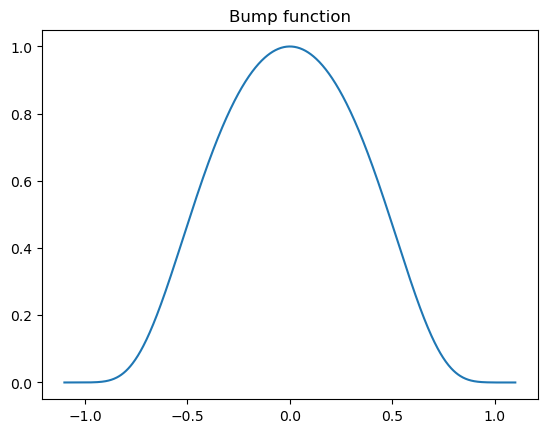

In [293]:
# plot bump function

x = np.linspace(-1.1, 1.1, 1000)
y = bump_function(x)
plt.plot(x, y)
plt.title("Bump function")
plt.show()

Luego re-escalamos y transladamos para tener una velocidad de producción máxima de $100000$ kg/dias y que la función tenga soporte en $[0,60]$, la duración de la temporada. Agregamos, además, ruido y calculamos la producción diaria.

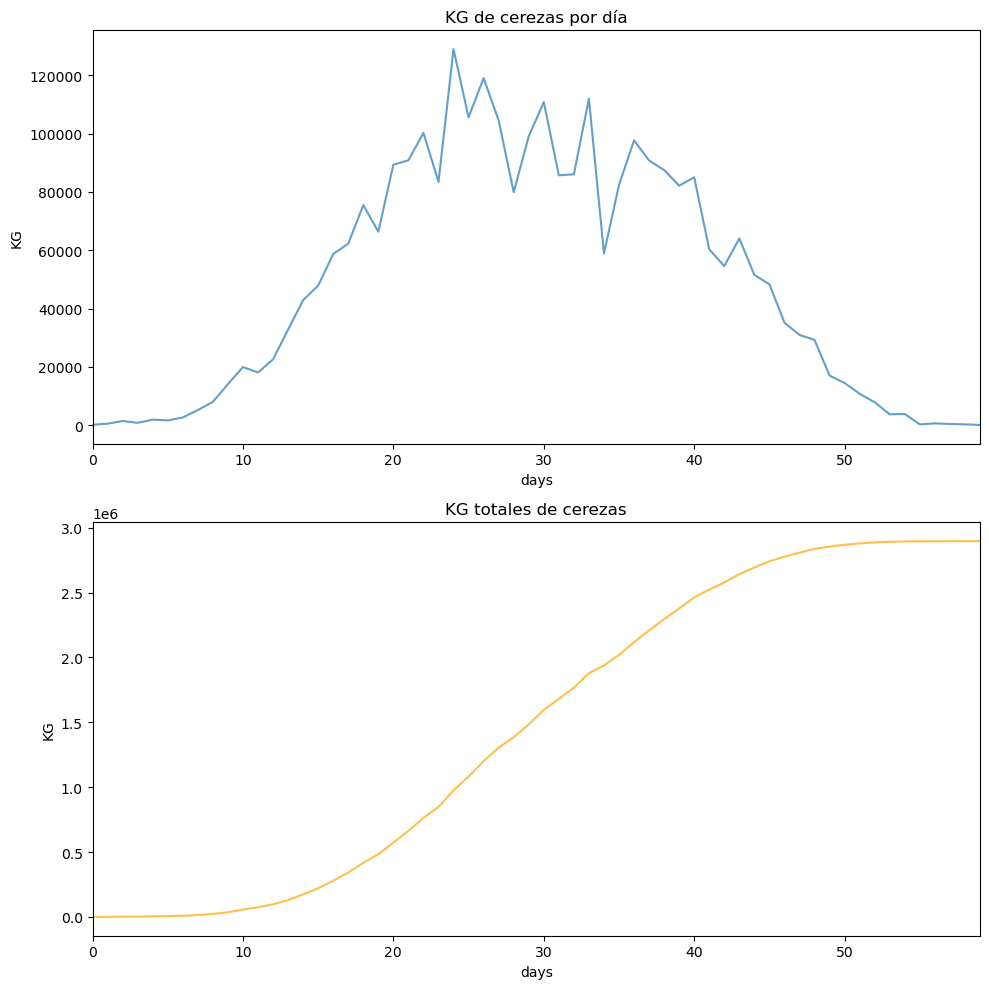

In [294]:
# Parameters
support = 60
maximum = 100_000

# Generate data
daily_production = descrete_noisy_bump(support, maximum)
cumulative_production = np.cumsum(daily_production)

# Define the x-axis range for days
days = np.arange(support)

# Plot the original `speed_of_production` function
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot the daily production
axs[0].plot(days, daily_production, alpha=0.7)
axs[0].set_xlabel("days")
axs[0].set_ylabel("KG")
axs[0].set_title("KG de cerezas por día")
axs[0].set_xlim(0, support - 1)

# Plot the cumulative production
axs[1].plot(days, cumulative_production, color="orange", alpha=0.7)
axs[1].set_xlabel("days")
axs[1].set_ylabel("KG")
axs[1].set_title("KG totales de cerezas")
axs[1].set_xlim(0, support - 1)

plt.tight_layout()
plt.show()


Ahora simulamos las predicciones de producción semanal del campo calculando la producción semanal real y agregando ruido Gaussiano; la cantidad estimada es una variable aleatoria con distribución normal, centrada en el valor real con desviación estándard de $15\%$ el valor real.

In [295]:
# Define the range based on the given support
max_multiple = support // 7
weeks = np.linspace(0, max_multiple * 7, max_multiple + 1, dtype=int)

# Integrate over each weekly interval and add noise
weekly_boxes = np.zeros(len(weeks))
for i, week in enumerate(weeks):
    start = week
    end = week + 7
    weekly_boxes[i] = np.sum(daily_production[start:end])


In [296]:
# Add noise to the integrated values
mean = 0
std_dev = 1
noise = np.random.normal(mean, std_dev, size=weekly_boxes.shape)

error = 0.15
weekly_boxes_estimation = np.maximum(weekly_boxes + noise * error * weekly_boxes, 0)

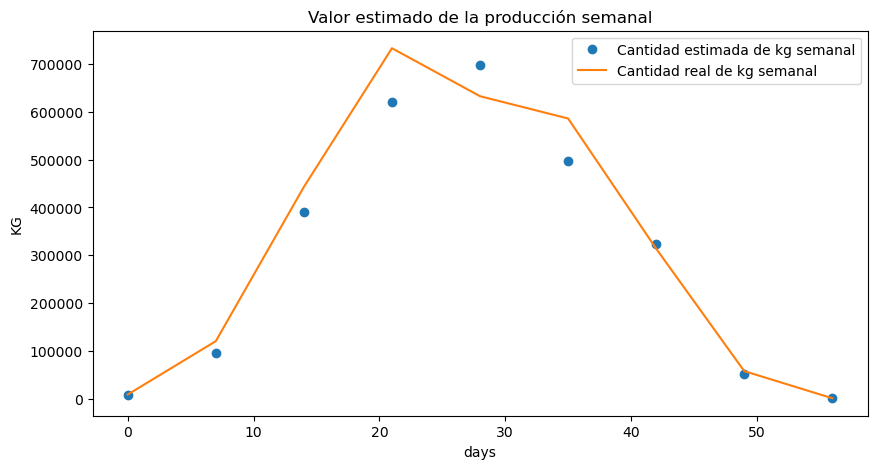

In [297]:
plt.figure(figsize=(10, 5))
plt.plot(weeks, weekly_boxes_estimation, "o", label="Cantidad estimada de kg semanal")
plt.plot(weeks, weekly_boxes, label="Cantidad real de kg semanal")
plt.legend()
plt.xlabel("days")
plt.ylabel("KG")
plt.title("Valor estimado de la producción semanal")
plt.show()

Obtenemos información inicial de los materiales. El DELIVERY TIME es un número aleatorio del 1 al 5 (distribución uniforme).

In [298]:
# Create a dummy stock data

item_names = [
    "MCER017",
    "MCER018",
    "MCER020",
    "MCER021",
    "MCER022",
    "MCER026",
    "MCER027",
    "MCER028",
    "MCER029",
    "MCER030",
    "MCER031",
    "MCER032",
    "MCER033",
    "MCER034",
    "MCER035",
    "MCER036",
    "MCER037",
    "MCER038",
    "MCER039",
    "MCER040",
    "MCER041",
    "MCER043",
    "MCER046",
    "MCER047",
    "MCER051",
    "MCER057",
    "MCER067",
]

ammount_of_items: int = len(item_names)

print("Item ammount: ", ammount_of_items)

items: list[str] = item_names
stock: list[int] = [0 for i in range(len(items))]
emergency_stock: list[int] = [0 for i in range(len(items))]
delivery_time: list[int] = [random.randint(1, 5) for i in range(len(items))]

stock_data: pd.DataFrame = pd.DataFrame(
    {
        "CODIGO": items,
        "STOCK": stock,
        "EMERGENCY STOCK": emergency_stock,
        "DELIVERY TIME": delivery_time,
    }
)



kg = pd.DataFrame(
    {
        "PACKING": ["packing"],
        "KG": [0],
    }
)

packings_dict = {"packing": stock_data}

print(stock_data.head())
print()
print(kg.head())

Item ammount:  27
    CODIGO  STOCK  EMERGENCY STOCK  DELIVERY TIME
0  MCER017      0                0              2
1  MCER018      0                0              3
2  MCER020      0                0              4
3  MCER021      0                0              3
4  MCER022      0                0              3

   PACKING  KG
0  packing   0


Modelamos la transformación de KG a tipos de caja de manera aleatoria; la cantidad de cajas que hacen $10$ KG de fruta es una variable aleatoria uniforme sobre los números enteros del 1 al 6.

In [299]:
# Create a dummy stock data
my_box_types = ["CGA8F1", "CGM8F1", "CGM8F", "PGMC2", "PGMCJ"]

ammount_of_box_types: int = len(my_box_types)

box_types: list[str] = my_box_types
# the information will be provided in how many boxes will be made with 10 kg of cherries
# that arrive at the packing.
boxes_per_10kg: list[int] = [random.randint(1, 6) for i in range(len(box_types))]

kg2box_df: pd.DataFrame = pd.DataFrame(
    {
        "BOX TYPE": box_types,
        "BOXES PER 10KG": boxes_per_10kg,
    }
)

print(kg2box_df.head())

  BOX TYPE  BOXES PER 10KG
0   CGA8F1               3
1   CGM8F1               4
2    CGM8F               4
3    PGMC2               1
4    PGMCJ               4


Simulamos la transformación de cajas a materiales con datos reales. Esta es la información de cuanto material ocupa cada caja de un tipo dado de caja.

In [300]:
box2material_dict = {}

materials_used_str = {
    "CGA8F1": """MCER046
MCER047
MCER022
MCER057
MCER027
MCER026
MCER029
MCER028
MCER030
MCER032
MCER036
MCER037
MCER067
MCER034
MCER033
""",
    "CGM8F1": """MCER046
MCER047
MCER021
MCER018
MCER057
MCER031
MCER038
MCER032
MCER035
MCER037
MCER067
MCER034
MCER033
""",
    "CGM8F": """MCER051
MCER039
MCER020
MCER017
MCER043
MCER031
MCER032
MCER035
MCER037
MCER067
MCER034
MCER033
""",
    "PGMC2": """MCER040
MCER041
MCER017
MCER031
MCER032
MCER035
MCER037
MCER067
MCER034
MCER033
""",
    "PGMCJ": """MCER040
MCER041
MCER017
MCER031
MCER032
MCER035
MCER037
MCER067
MCER034
MCER033
""",
}

ammounts_used_str = {
    "CGA8F1": """1
1
1
1
0.00357
0.00357
0.00357
0.00357
0.00357
0.00357
0.01429
0.00357
0.01429
0.25714
0.05357
""",
    "CGM8F1": """1
1
1
1
1
0.00238
0.00714
0.00238
0.00952
0.00238
0.00952
0.18333
0.03095
""",
    "CGM8F": """1
1
1
1
1
0.00238
0.00714
0.00238
0.00952
0.00238
0.00952
0.18333
0.03095
""",
    "CGM8F": """1
1
1
1
1
0.00543
0.01087
0.02174
0.00543
0.02174
0.41848
0.07065
""",
    "PGMC2": """1
1
1
0.00893
0.00893
0.03571
0.00893
0.03571
0.68750
0.11607
""",
    "PGMCJ": """1
1
1
0.00893
0.00893
0.03571
0.00893
0.03571
0.68750
0.11607
""",
}


def long_str_to_list_str(long_str: str) -> list[str]:
    return [i for i in long_str.split("\n") if i!=""]

def long_str_to_list_float(long_str: str) -> list[float]:
    return [float(i) for i in long_str.split("\n") if i!=""]


for box_type in my_box_types:
    code = long_str_to_list_str(materials_used_str[box_type])
    x_box = long_str_to_list_float(ammounts_used_str[box_type])

    box2material_dict[box_type] = pd.DataFrame(
        {
            "CODIGO": code,
            "X CAJA": x_box,
        }
    )

for box_type in my_box_types:
    print(box_type)
    print(box2material_dict[box_type].head())
    print()

CGA8F1
    CODIGO   X CAJA
0  MCER046  1.00000
1  MCER047  1.00000
2  MCER022  1.00000
3  MCER057  1.00000
4  MCER027  0.00357

CGM8F1
    CODIGO  X CAJA
0  MCER046     1.0
1  MCER047     1.0
2  MCER021     1.0
3  MCER018     1.0
4  MCER057     1.0

CGM8F
    CODIGO  X CAJA
0  MCER051     1.0
1  MCER039     1.0
2  MCER020     1.0
3  MCER017     1.0
4  MCER043     1.0

PGMC2
    CODIGO   X CAJA
0  MCER040  1.00000
1  MCER041  1.00000
2  MCER017  1.00000
3  MCER031  0.00893
4  MCER032  0.00893

PGMCJ
    CODIGO   X CAJA
0  MCER040  1.00000
1  MCER041  1.00000
2  MCER017  1.00000
3  MCER031  0.00893
4  MCER032  0.00893



## Simulación

Modelamos e inicializamos un packing con la información de la sección anterior.

In [301]:
packings = [
        Packing(name, materials, kg2box_df, box2material_dict)
        for name, materials in packings_dict.items()
]

packing = packings[0]

print(packing)

packing:
MCER017: 0 unidades/ inf min/ inf max
MCER018: 0 unidades/ inf min/ inf max
MCER020: 0 unidades/ inf min/ inf max
MCER021: 0 unidades/ inf min/ inf max
MCER022: 0 unidades/ inf min/ inf max
MCER026: 0 unidades/ inf min/ inf max
MCER027: 0 unidades/ inf min/ inf max
MCER028: 0 unidades/ inf min/ inf max
MCER029: 0 unidades/ inf min/ inf max
MCER030: 0 unidades/ inf min/ inf max
MCER031: 0 unidades/ inf min/ inf max
MCER032: 0 unidades/ inf min/ inf max
MCER033: 0 unidades/ inf min/ inf max
MCER034: 0 unidades/ inf min/ inf max
MCER035: 0 unidades/ inf min/ inf max
MCER036: 0 unidades/ inf min/ inf max
MCER037: 0 unidades/ inf min/ inf max
MCER038: 0 unidades/ inf min/ inf max
MCER039: 0 unidades/ inf min/ inf max
MCER040: 0 unidades/ inf min/ inf max
MCER041: 0 unidades/ inf min/ inf max
MCER043: 0 unidades/ inf min/ inf max
MCER046: 0 unidades/ inf min/ inf max
MCER047: 0 unidades/ inf min/ inf max
MCER051: 0 unidades/ inf min/ inf max
MCER057: 0 unidades/ inf min/ inf max
MCE

Simulamos el stock de cada material del packing durante los $60$ días. Para esto

Definimos el stock inicial como el stock máximo que sugiere el programa para esa fecha y realizamos la siguiente rutina para cada día:
* Restamos los materiales usados este día del stock total.
* Actualizamos el stock de haber llegado el pedido de reposición (se define como el máximo sugerido por el programa).
* Calculamos el stock mínimo y máximo con el programa.
* Revisamos si hay menos stock que el mínimo sugerido por el programa. Si hay menos stock, se realiza un pedido de reposición de no existir uno actualmente.

In [302]:
days = range(support)

# We start with good stock
weekly_boxes_estimation_in_days = [
    value for week_value in weekly_boxes_estimation for value in [week_value] * 7
]

packing.update_minimum_and_maximum_stocks(weekly_boxes_estimation_in_days[0])
for material in packing:
    material.stock = material.maximum_stock
packing.reset_history()

order_day = {material.name: [] for material in packing}
stock_schedule = {material.name: (False, None) for material in packing}
for day in tqdm(days):
    for material in packing:
        today_kg = daily_production[day]
        name = material.name

        boxes_used_today = {box_type: None for box_type in packing.kg2box["BOX TYPE"]}
        for _, row in packing.kg2box.iterrows():
            box_type = row["BOX TYPE"]
            boxes_per_10kg = row["BOXES PER 10KG"]
            boxes_used_today[box_type] = today_kg / 10 * boxes_per_10kg

        item = lambda df: df.values[0] if len(df) > 0 else 0
        material_used_today = 0
        for box_type in boxes_used_today:
            material_used_today += item(
                packing.box2material[box_type].loc[
                    packing.box2material[box_type]["CODIGO"] == name, "X CAJA"
                ]
            ) * boxes_used_today[box_type]
        material.stock -= material_used_today

    for material in packing:
        if not material.enough_stock:
            days_waited, expecting = stock_schedule[material.name]
            if days_waited >= material.delivery_time:
                stock_schedule[material.name] = (False, None)
                material.stock = expecting

    packing.update_minimum_and_maximum_stocks(weekly_boxes_estimation_in_days[day])
    packing.round_values()

    for material in packing:
        if not material.enough_stock:
            days_waited, expecting = stock_schedule[material.name]
            if not type(days_waited) == int:
                expecting = material.maximum_stock
                stock_schedule[material.name] = (0, expecting)
                order_day[material.name].append(day)
            else:
                stock_schedule[material.name] = (days_waited + 1, expecting)

100%|██████████| 60/60 [00:03<00:00, 15.56it/s]


Graficamos el stock mínimo, el stock máximo, el stock y las fechas de pedido de cada material.

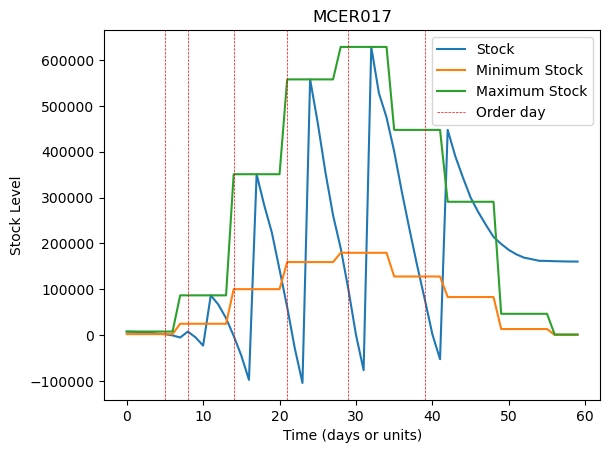

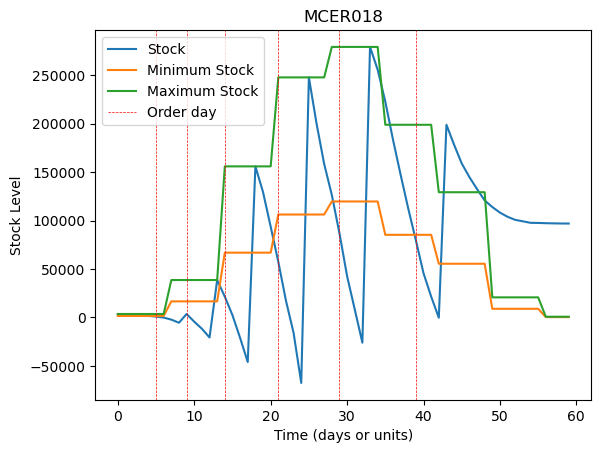

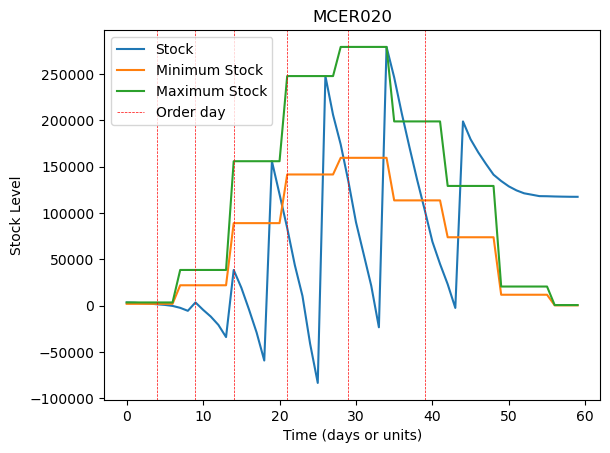

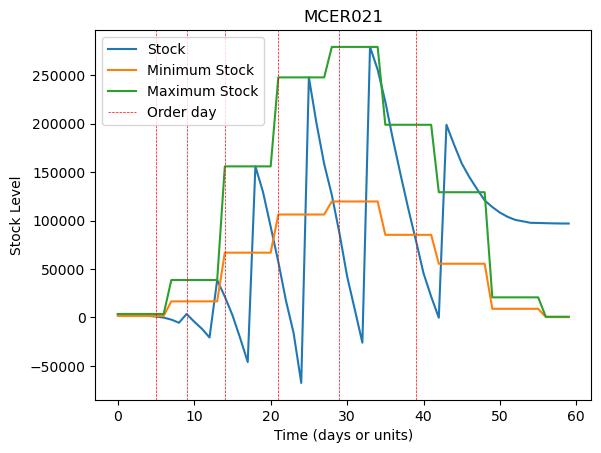

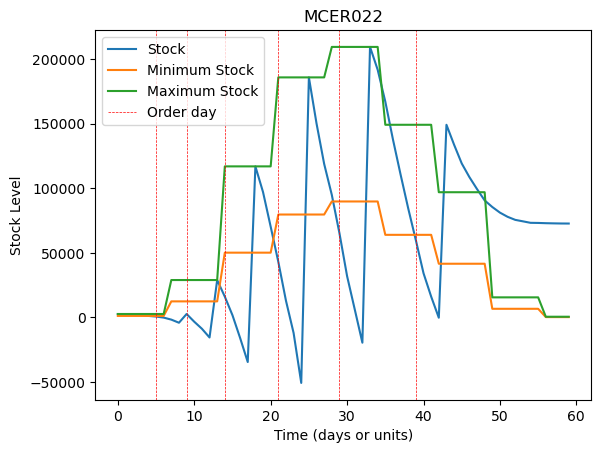

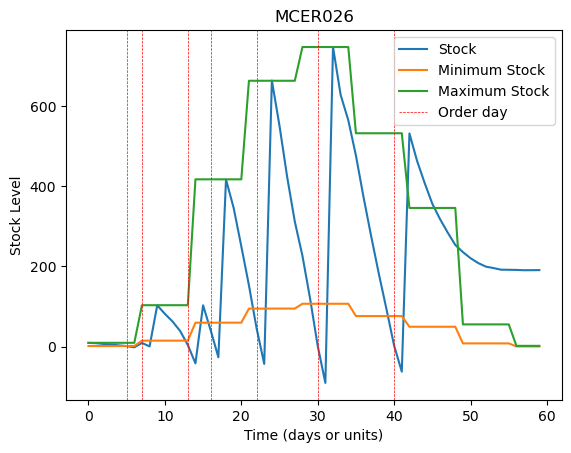

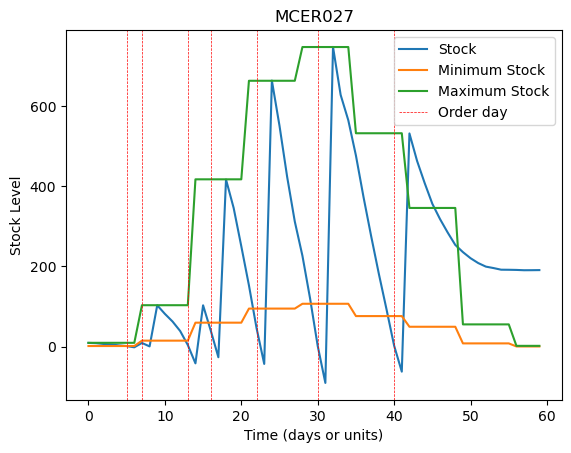

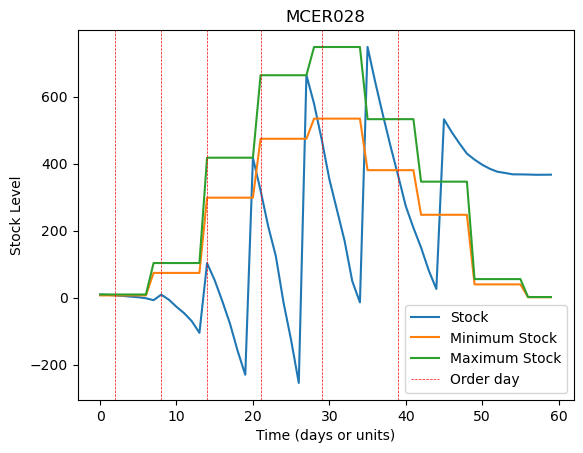

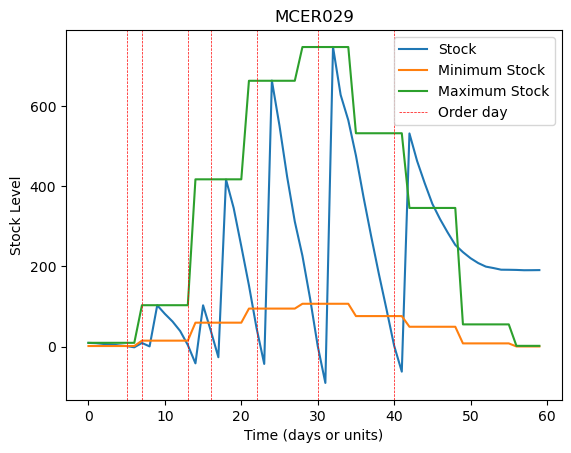

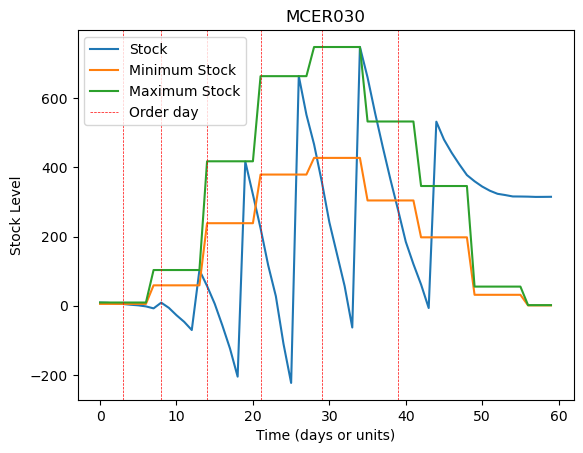

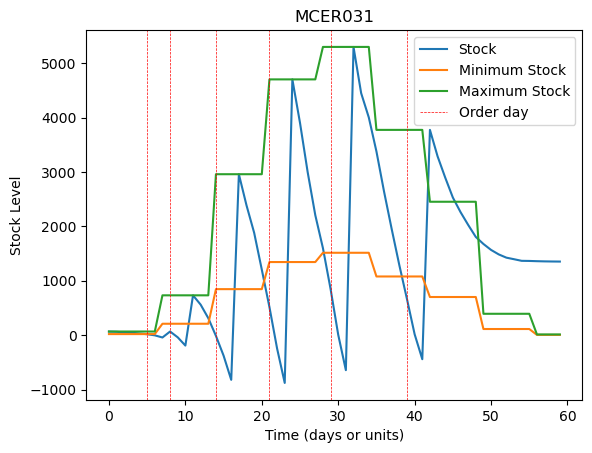

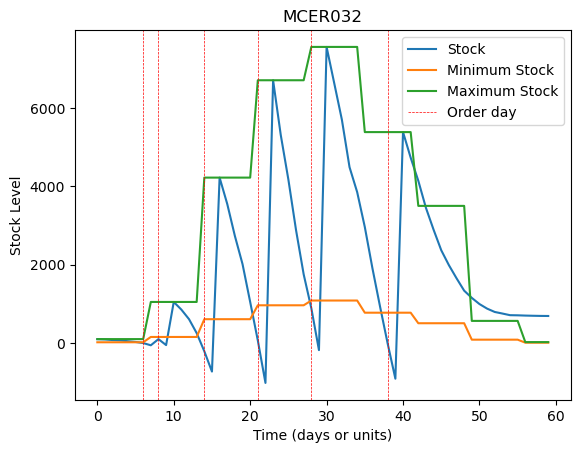

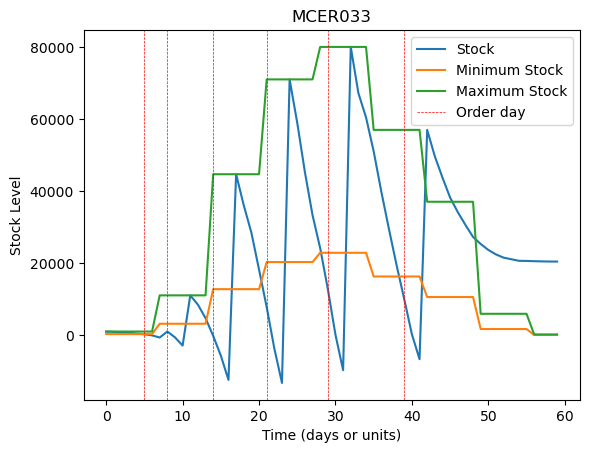

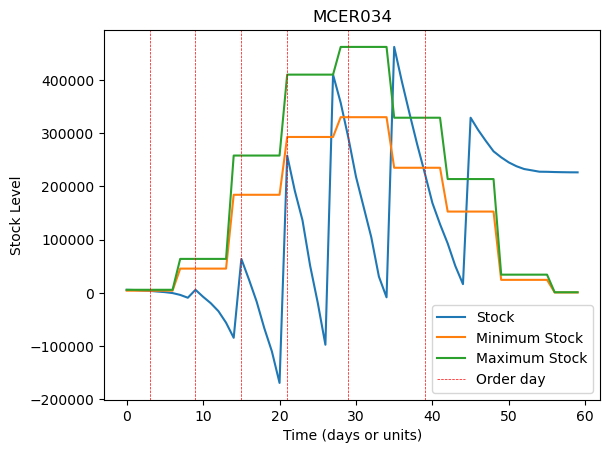

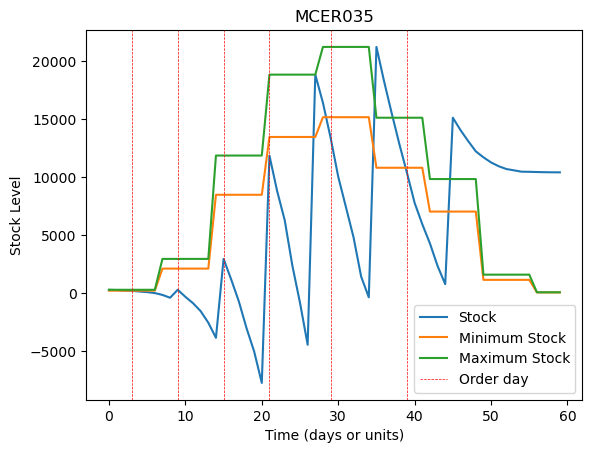

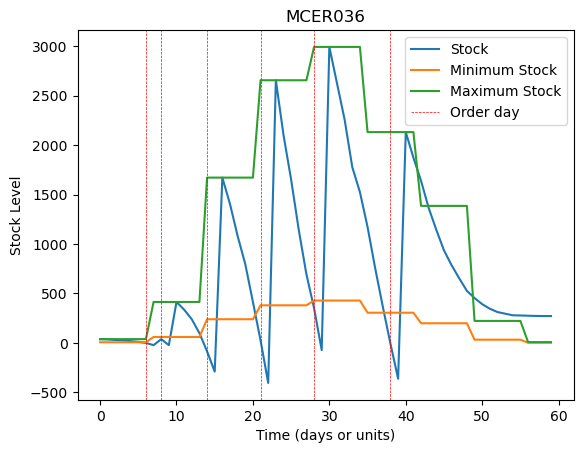

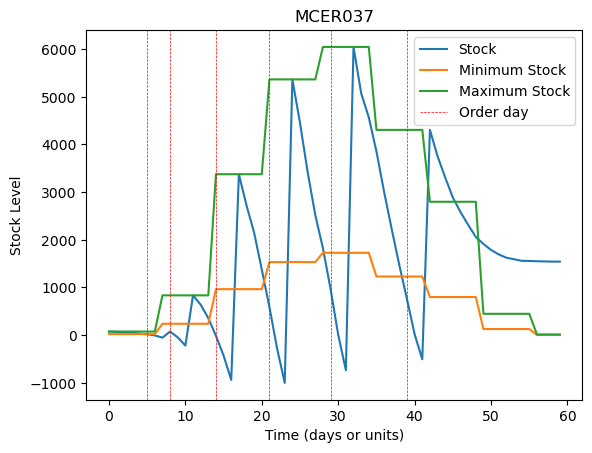

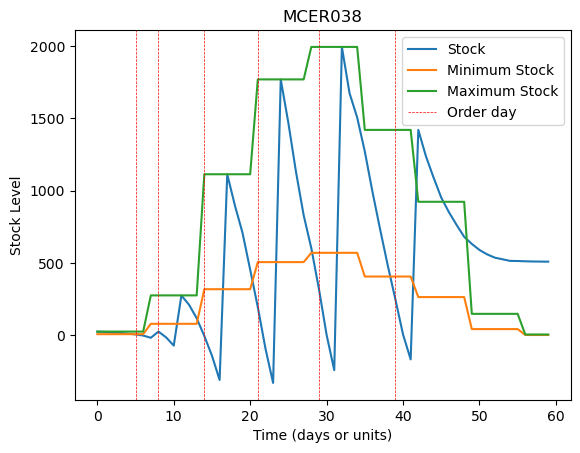

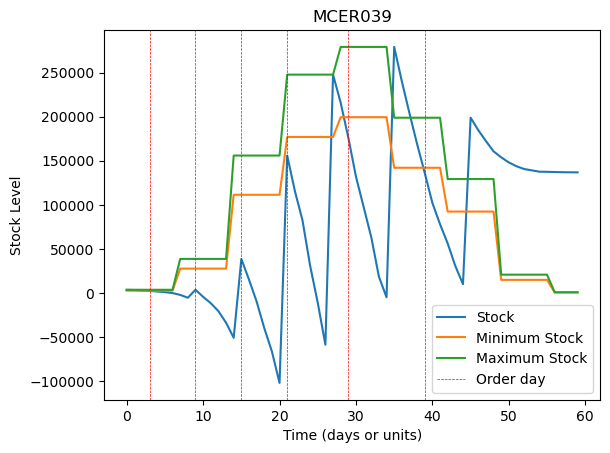

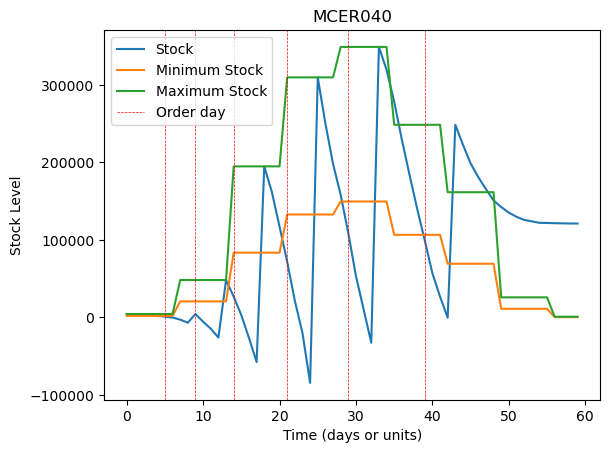

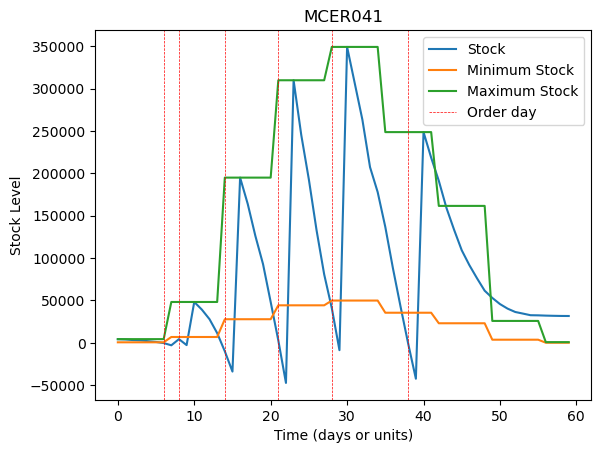

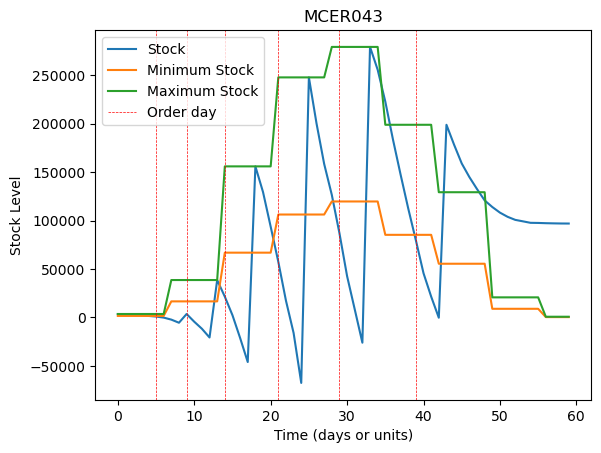

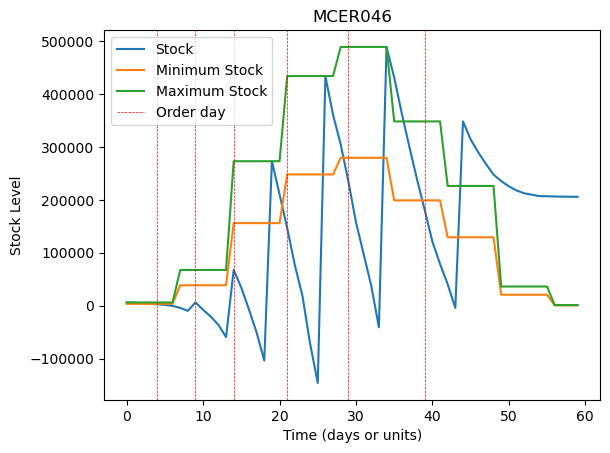

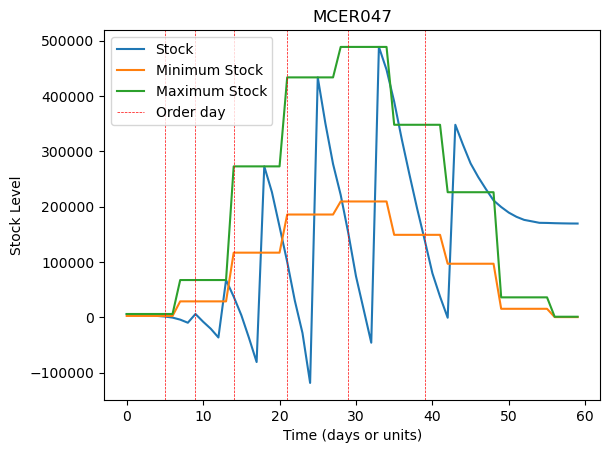

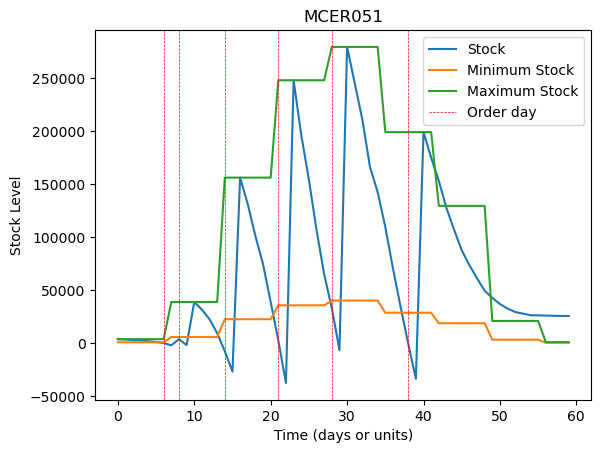

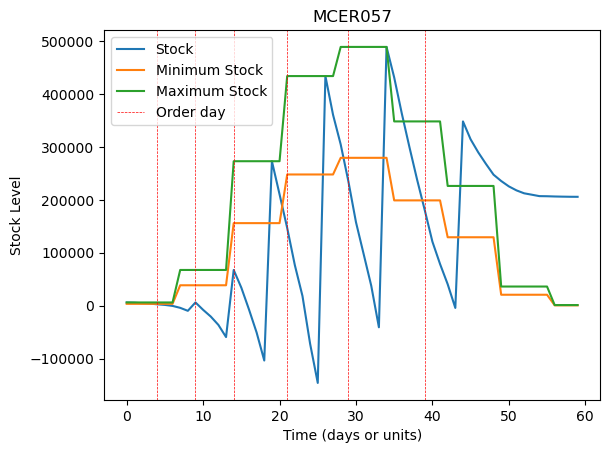

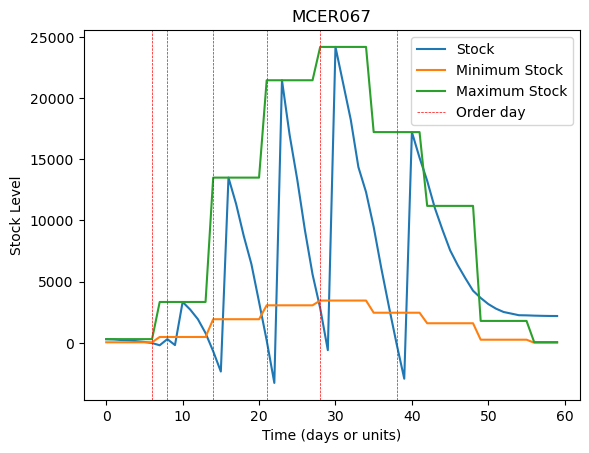

In [303]:
for material in packing:

    # Create a new figure for each material
    plt.figure()

    # Use len() to get the correct range for x-axis
    plt.plot(
        range(len(material.history["stock"])), material.history["stock"], label="Stock"
    )
    plt.plot(
        range(len(material.history["minimum_stock"])),
        material.history["minimum_stock"],
        label="Minimum Stock",
    )
    plt.plot(
        range(len(material.history["maximum_stock"])),
        material.history["maximum_stock"],
        label="Maximum Stock",
    )
    days_ordered = order_day[material.name]
    for day in days_ordered:
        plt.axvline(
            x=day,
            color="r",
            linestyle="--",
            linewidth=0.5,
            label="Order day" if day == days_ordered[0] else "",
        )

    # Set title and labels
    plt.title(material.name)
    plt.xlabel("Time (days or units)")  # Adjust label as necessary
    plt.ylabel("Stock Level")

    # Show legend
    plt.legend()

    # Display the plot
    plt.show()